# Warping as measured by distance ratio

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_style("whitegrid") #  {darkgrid, whitegrid, dark, white, ticks}
sns.set_context("talk")

In [2]:
def load_results(results_fn, rep_name):
    """
        Function to load the results
            - result_fn: the path to the result folder
            - rep_name: what type of representation to use (e.g, the averaged representations)
    """

    results_dir = '../results/'
    results_path = os.path.join(results_dir,results_fn)
    
    with open(results_path, 'rb') as f:
        data = pickle.load(f)
    
    # Get ratio results
    analysis = data['analysis']
    ratios = []
    for run in analysis:
        ratios.append([s['distance_ratio'][rep_name]['ratio'] for s in run])
    dist_ratios = np.array(ratios)
    
    # Get congruent vs. incongruent accuracy results
    results = data['results']
    cong_accs = []
    incong_accs = []
    for run in results:
        cong_accs.append([s['cong_acc'] for s in run['train_accs']])
        incong_accs.append([s['incong_acc'] for s in run['train_accs']])
    cong_accs = np.mean(cong_accs, axis=0)
    incong_accs = np.mean(incong_accs, axis=0)
    acc_ratios = incong_accs/cong_accs
    return dist_ratios, acc_ratios

In [3]:
def plot_ratio(dist_ratios, acc_ratios, title, save_fn):
    """
        Function to plot the ratio results
            - dist_ratios: the warping (distance ratio) data
            - acc_ratios: the ration of incongruent over the congruent accuracies
            - title: title for the plot
            - save_fn: filename to save the result
    """
    color = 'tab:blue'
    n_checkpoints = len(acc_ratios)
    fig, ax = plt.subplots(figsize=(20,6))
    ax = sns.boxplot(data=dist_ratios, color=color)
    ax = sns.stripplot(data=dist_ratios, color=color)
    ax.axhline(y=1, color='r', linewidth=2)
    ax = sns.lineplot(data=acc_ratios, color='black', err_style="bars", markers=True, dashes=False)
    ax.set_title(title)
    ax.legend(["Accuracy Ratio (incongruent / congruent)"])
    ax.set_xticklabels([i*analyze_every for i in range(n_checkpoints)])
    ax.set_xlabel("Steps")
    ax.set_ylabel("Ratio (incongruent / congruent)")
    ax.set_ylim([0.0, 1.6])
    
    # Save figure
    if save_fn is not None:
        #plt.savefig(save_fn, dpi=1000, format='eps', bbox_inches='tight')
        plt.savefig(save_fn, dpi=1000, format='png', bbox_inches='tight')
    
    plt.show()

In [4]:
def make_tsv(model_name = 'rnn'):
    """
        Funciton to save the results as a tsv file
        - model_name: what model to use 
    """
    in_dir = '../results/' #'Path to results directory with pickle files
    out_dir = '../results/tsv/' #Path to directory to output tsv files
    # Make output directory
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)

    # Load basic results
    fn = os.path.join(in_dir, f"{model_name}.P")
    with open(fn, 'rb') as f:
        results = pickle.load(f)
    analysis = results['analysis']
    # Warping results (t-test and ratio)
    header = []
    data = []
    for run_i, run in enumerate(analysis):
        # T-test results
        for stat in ['t_statistic', 'p_value']:
            # Get column of data
            col = np.array([s['ttest'][rep_name][stat] for s in run])
            col = np.expand_dims(col, axis=1)
            data.append(col)

            # Header
            run_name = f"run{run_i}"
            stat_name = stat.replace('_', '-')
            head = f"{run_name}_{stat_name}"
            header.append(head)

        # Ratio results
        for stat in ['ratio', 'ave_cong_dist', 'ave_incong_dist']:
            # Get column 
            col = np.array([s['distance_ratio'][rep_name][stat] for s in run])
            col = np.expand_dims(col, axis=1)
            data.append(col)

            # Header
            run_name = f"run{run_i}"
            stat_name = stat.replace('_', '-')
            head = f"{run_name}_{stat_name}"
            header.append(head)
    data = np.concatenate(data, axis=1) # [n_steps, n_runs * n_stats * n_vars]
    header = "\t".join(header) # n_runs * n_stats * n_vars
    out_file = os.path.join(out_dir, f'warping_{model_name}.tsv')
    print(f"Writing warping results to {out_file}")
    header_len = len(header.split('\t'))
    print(f"Shape = {data.shape}, header = {header_len}")
    np.savetxt(out_file, data, delimiter='\t', header=header)

Loading the results

In [5]:
results_fn = 'rnn.P'
rep_name = 'average'
# steps at each we do the analysis (e.g, do the analysis every 50 steps)
analyze_every = 50 
title = "Distance ratio vs. Accuracy ratio"
save_fn = '../figures/rnn_ratio.png'

In [6]:
dist_ratios, acc_ratios = load_results(results_fn, rep_name)

Plotting the t-stat results

- each dot shows one run 

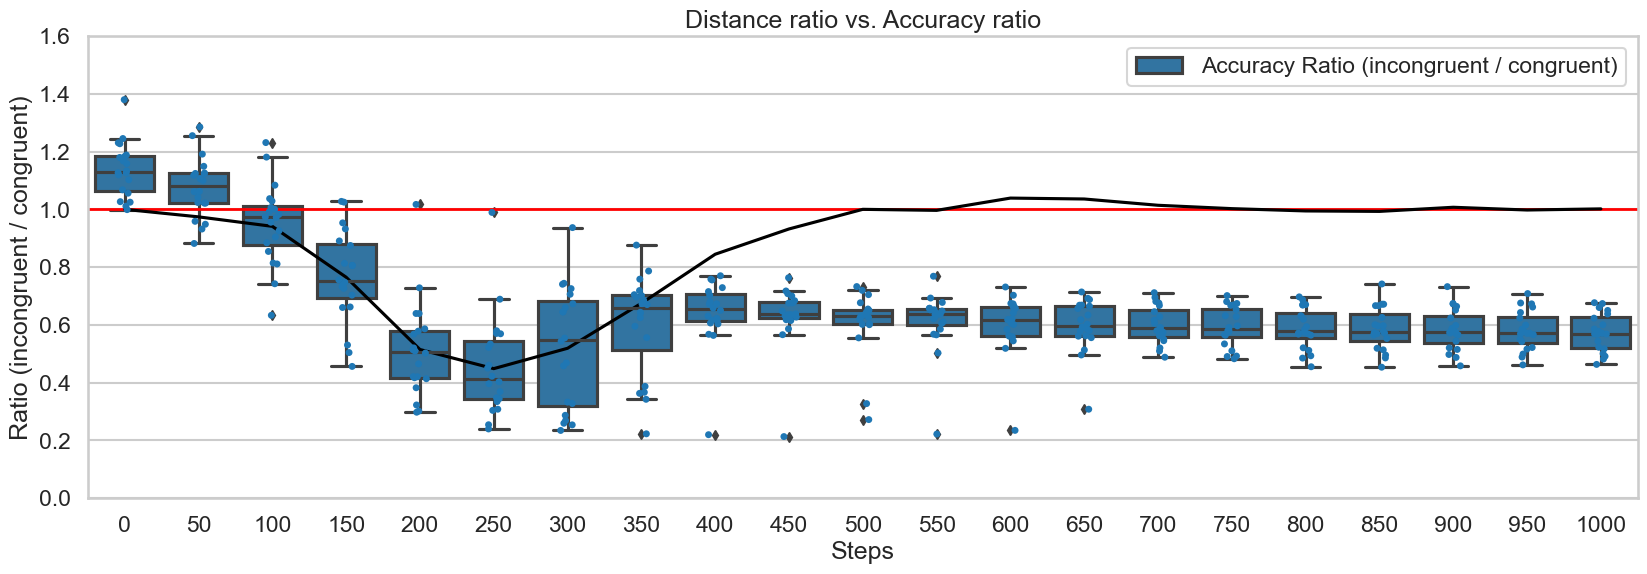

In [7]:
plot_ratio(dist_ratios, acc_ratios, title, save_fn)

In [8]:
make_tsv('rnn')

Writing warping results to ../results/tsv/warping_rnn.tsv
Shape = (21, 100), header = 100
